Prototyping LFM for Rating Prediction

In [1]:
! wget -q --show-progress -O ../data/ML100K.csv "https://drive.google.com/uc?export=download&id=1jmiAP_yNUMqqrMRL0m9_9txVrXoy7Pjl"

../data/ML100K.csv  100%[===================>] 947.92K  4.76MB/s    in 0.2s    


In [2]:
import pandas as pd

df = pd.read_csv("../data/ML100K.csv")
print(df.head())

   userId  movieId  rating
0       0        0       3
1       1        1       3
2       2        2       1
3       3        3       2
4       4        4       1


In [3]:
import torch
from torch.utils.data import Dataset
from loguru import logger

class MovieLensDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        df = pd.read_csv(self.data_path)

        self.users = torch.tensor(df["userId"].values, dtype=torch.long)
        self.items = torch.tensor(df["movieId"].values, dtype=torch.long)
        self.ratings = torch.tensor(df["rating"].values, dtype=torch.float32)

        self.num_users = df["userId"].nunique()
        self.num_items = df["movieId"].nunique()

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

dataset = MovieLensDataset(data_path="../data/ML100K.csv")
logger.info(f"Number of users: {dataset.num_users}")
logger.info(f"Number of items: {dataset.num_items}")
logger.info(f"Number of ratings: {len(dataset)}")

2025-03-05 04:02:51.734 | INFO     | __main__:<module>:24 - Number of users: 943
2025-03-05 04:02:51.735 | INFO     | __main__:<module>:25 - Number of items: 1682
2025-03-05 04:02:51.735 | INFO     | __main__:<module>:26 - Number of ratings: 100000


In [4]:
from torch.utils.data import DataLoader, random_split

train_ratio = 0.8
valid_ratio = 0.1
seed = 42
batch_size = 128

total_size = len(dataset)
train_size = int(train_ratio * total_size)
valid_size = int(valid_ratio * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    dataset=dataset,
    lengths=[train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

users, items, ratings = next(iter(test_loader))
print("Print test samples:")
print("First five users: ", users[0:5])
print("First five items: ", items[0:5])
print("First five ratings: ", ratings[0:5])

Print test samples:
First five users:  tensor([532, 534, 359, 110, 248])
First five items:  tensor([340, 371, 630, 156, 385])
First five ratings:  tensor([3., 3., 4., 3., 3.])


In [12]:
import torch
import torch.nn as nn

class LFM(nn.Module):
    def __init__(
        self,
        num_users,
        num_items,
        embedding_dim = 50
    ):
        super(LFM, self).__init__()

        self.global_bias = nn.Parameter(torch.zeros(1))
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(
        self,
        users, 
        items
    ):
        user_vecs = self.user_emb(users) # B x d
        item_vecs = self.item_emb(items) # B x d

        user_b = self.user_bias(users).squeeze() # B x 1
        item_b = self.item_bias(items).squeeze() # B x 1

        return self.global_bias + user_b + item_b + (user_vecs * item_vecs).sum(dim=1)

In [6]:
embedding_dim = 64

model = LFM(
    num_users=dataset.num_users,
    num_items=dataset.num_items,
    embedding_dim=embedding_dim
)

logger.info("Parameters:")
for name, param in model.named_parameters():
    logger.info(f"{name}: {param.shape}")

2025-03-05 04:02:59.455 | INFO     | __main__:<module>:9 - Parameters:
2025-03-05 04:02:59.456 | INFO     | __main__:<module>:11 - global_bias: torch.Size([1])
2025-03-05 04:02:59.456 | INFO     | __main__:<module>:11 - user_bias.weight: torch.Size([943, 1])
2025-03-05 04:02:59.457 | INFO     | __main__:<module>:11 - item_bias.weight: torch.Size([1682, 1])
2025-03-05 04:02:59.457 | INFO     | __main__:<module>:11 - user_emb.weight: torch.Size([943, 64])
2025-03-05 04:02:59.458 | INFO     | __main__:<module>:11 - item_emb.weight: torch.Size([1682, 64])


In [7]:
import random
import numpy as np

def set_random_seed(seed):
    logger.info(f"Setting random seed: {seed}")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(seed=seed)

2025-03-05 04:03:00.893 | INFO     | __main__:set_random_seed:5 - Setting random seed: 42


In [13]:
import torch.optim as optim
from tqdm.notebook import tqdm

num_epochs = 30
lr = 0.001
weight_decay = 0.000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

model = model.to(device)
optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
criterion = nn.MSELoss()

2025-03-05 04:03:35.349 | INFO     | __main__:<module>:9 - Using device: cuda


In [9]:
import math

def train_or_eval_epoch(data_loader, training):
    model.train(training)
    if training is False:
        model.eval()

    total_loss, total_samples = 0.0, 0

    desc = "Training" if training else "Validating"
    batch_bar = tqdm(data_loader, desc=f"{desc} RMSE: 0.0000", leave=False)

    with torch.set_grad_enabled(training):
        for batch in batch_bar:
            users, items, ratings = tuple(t.to(device) for t in batch)
            predictions = model(users, items)

            loss = criterion(predictions, ratings)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            batch_size = users.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            avg_score = math.sqrt(total_loss / total_samples) # RMSE
            batch_bar.set_description(f"{desc} RMSE: {avg_score:.4f}")

    batch_bar.close()
    return math.sqrt(total_loss / total_samples)

In [14]:
best_model_state = None
best_valid_score = float("inf")

epoch_bar = tqdm(range(num_epochs), desc="Epoch Progress", leave=True)
train_scores = []
valid_scores = []
for epoch in epoch_bar:
    train_score = train_or_eval_epoch(train_loader, training=True)
    valid_score = train_or_eval_epoch(valid_loader, training=False)

    if valid_score < best_valid_score: # lower RMSE is better
        best_valid_score = valid_score
        best_model_state = {
            k: v.clone().detach() for k, v in model.state_dict().items()
        }

    epoch_bar.set_description(
        f"Epoch {epoch+1} - Train RMSE: {train_score:.4f}, Valid RMSE: {valid_score:.4f}"
    )
    train_scores.append(train_score)
    valid_scores.append(valid_score)

Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

Training RMSE: 0.0000:   0%|          | 0/625 [00:00<?, ?it/s]

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

In [15]:
logger.info(f"Random seed: {seed}")
logger.info(f"Hyperparameters:")
logger.info(f"- Embedding dimension: {embedding_dim}")
logger.info(f"- Learning rate: {lr}")
logger.info(f"- Weight decay: {weight_decay}")
logger.info(f"- Batch size: {batch_size}")
logger.info(f"Best valid RMSE: {best_valid_score:.4f}")

2025-03-03 01:32:26.945 | INFO     | __main__:<module>:1 - Random seed: 42
2025-03-03 01:32:26.946 | INFO     | __main__:<module>:2 - Hyperparameters:
2025-03-03 01:32:26.947 | INFO     | __main__:<module>:3 - - Embedding dimension: 64
2025-03-03 01:32:26.947 | INFO     | __main__:<module>:4 - - Learning rate: 0.001
2025-03-03 01:32:26.948 | INFO     | __main__:<module>:5 - - Weight decay: 0.0
2025-03-03 01:32:26.948 | INFO     | __main__:<module>:6 - - Batch size: 128
2025-03-03 01:32:26.948 | INFO     | __main__:<module>:7 - Best valid RMSE: 0.9215


In [16]:
model.load_state_dict(best_model_state)
model.to(device)
test_score = train_or_eval_epoch(test_loader, training=False)
logger.info(f"Final Test RMSE: {test_score:.4f}")

Validating RMSE: 0.0000:   0%|          | 0/79 [00:00<?, ?it/s]

2025-03-03 01:32:41.381 | INFO     | __main__:<module>:4 - Final Test RMSE: 0.9309


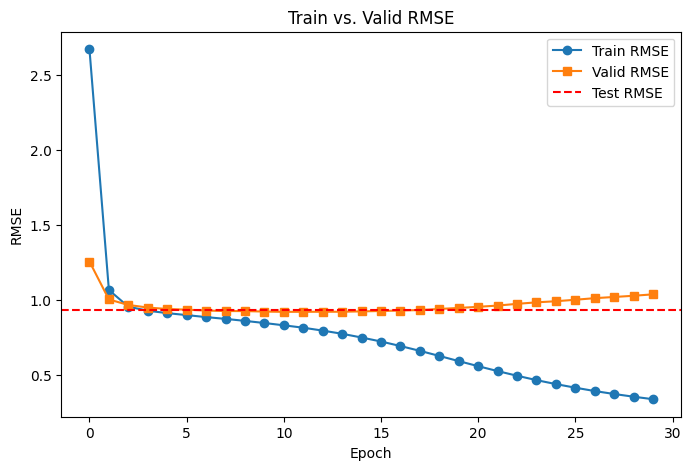

In [17]:
import matplotlib.pyplot as plt

epochs = list(range(0, num_epochs))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_scores, marker='o', linestyle='-', label="Train RMSE")
plt.plot(epochs, valid_scores, marker='s', linestyle='-', label="Valid RMSE")
plt.axhline(y=test_score, color='r', linestyle='dashed', label='Test RMSE') 

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Valid RMSE")
plt.legend()

plt.show()